In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
#load data
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
with open(os.path.join(full_folder_path,"Aug7_1mil.pkl"), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
numevents=len(clean_data_dict['2_phi'])
print("number of events:",numevents)

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])

dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [3]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'charge_2', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'charge_3', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'], 
    ['deltaphi_13', 'deltaeta_13', 'deltaR_13', 'mt_13', 'norm_mt_13'], 
    ['deltaphi_23', 'deltaeta_23', 'deltaR_23', 'mt_23', 'norm_mt_23']
]

lepton_input_ordered = input_data_names_ordered[1:]
lepton_output_ordered = used_labels2[3:]

l_input_shape=(numevents,len(lepton_input_ordered), len(lepton_input_ordered[0]))
print("events, particles, input features: ",l_input_shape)
l_input= np.empty(l_input_shape)

for i in range(len(lepton_input_ordered)):
    for j, feature in enumerate(lepton_input_ordered[i]):
        l_input[:,i,j] = data_dict_np[feature]

l_output_shape=(numevents, len(lepton_output_ordered), len(lepton_output_ordered[0]))
print("events, particle pairs, output kin. features: ",l_output_shape)
l_output= np.empty(l_output_shape)

for i in range(len(lepton_output_ordered)):
    for j, feature in enumerate(lepton_output_ordered[i]):
        l_output[:,i,j] = data_dict_np[feature]

lepton_pair_order = pair_order[3:]
lepton_particle_order = input_data_particle_order[1:]
print("lepton pair order: ", lepton_pair_order)
print("lepton particle order: ", lepton_particle_order)

events, particles, input features:  (568554, 3, 5)
events, particle pairs, output kin. features:  (568554, 3, 5)
lepton pair order:  ['1_2', '1_3', '2_3']
lepton particle order:  ['1', '2', '3']


## normalizing ##

In [4]:
def normalize_l(data):
    # l_input_reshaped=l_input.reshape(l_input.shape[0], -1)
    # print("input reshaped shape:",l_input_reshaped.shape)
    # scaler = StandardScaler()
    # data_normalized = scaler.fit_transform(l_input_reshaped)

    means = data.mean(axis=(0))
    stds = data.std(axis=(0))
    # print("means shape:",means.shape)

    data_normalized = (data - means) / (stds + 1e-10)
    return data_normalized, means, stds

n_l_input, _, _ = normalize_l(l_input)
print("normalized input shape:",n_l_input.shape)


n_l_output, l_output_means, l_output_stds = normalize_l(l_output)
print("normalized output shape:",n_l_output.shape)

def invert_normalize(data_normalized, means, stds):
    return (data_normalized * stds) + means



normalized input shape: (568554, 3, 5)
normalized output shape: (568554, 3, 5)


In [5]:
linput_tensor = torch.tensor(n_l_input, dtype=torch.float32)
llabel_tensor = torch.tensor(n_l_output, dtype=torch.float32)

lpairs_data=[]
lpairs_labels=[]

# lepton_pair_order = ['1_2', '1_3', '2_3']
lepton_pair_mapping={(0,1): lepton_pair_order.index('1_2'), (0,2): lepton_pair_order.index('1_3'), (1,2): lepton_pair_order.index('2_3')}

for key, value in lepton_pair_mapping.items():
    concatonated_data=torch.cat((linput_tensor[:,key[0],:], linput_tensor[:,key[1],:]), dim=1)
    lpairs_data.append(concatonated_data)

    lpairs_labels.append(llabel_tensor[:,value,:])

print(len(lpairs_data), len(lpairs_labels))
print(lpairs_data[0].shape, lpairs_labels[0].shape)

3 3
torch.Size([568554, 10]) torch.Size([568554, 5])


In [6]:
train_data_list = []
val_data_list = []
test_data_list = []
train_labels_list = []
val_labels_list = []
test_labels_list = []

for pair_idx in range(len(lpairs_data)):
    pair_data = lpairs_data[pair_idx]
    pair_labels = lpairs_labels[pair_idx]

    train_val_data, test_data, train_val_labels, test_labels = train_test_split(pair_data, pair_labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=42)

    train_data_list.append(train_data)
    val_data_list.append(val_data)
    test_data_list.append(test_data)
    train_labels_list.append(train_labels)
    val_labels_list.append(val_labels)
    test_labels_list.append(test_labels)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class KinematicNet(nn.Module):
    def __init__(self):
        super(KinematicNet, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 200)
        self.fc3 = nn.Linear(200, 128)
        self.fc4 = nn.Linear(128, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

model = KinematicNet()
model.to(device)



cuda:0


KinematicNet(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=5, bias=True)
)

In [8]:
import torch
import torch.nn as nn
import numpy as np

def train_one_epoch(model, train_data_list, train_labels_list, optimizer, loss_fn, device):
    model.train()
    total_train_loss = 0

    for pair_idx in range(len(train_data_list)):
        train_data = train_data_list[pair_idx].to(device)
        train_label = train_labels_list[pair_idx].to(device)

        y_pred = model(train_data)
        loss = loss_fn(y_pred, train_label)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_data_list)
    return avg_train_loss

def validate_model(model, val_data_list, val_labels_list, loss_fn, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for pair_idx in range(len(val_data_list)):
            val_data = val_data_list[pair_idx].to(device)
            val_label = val_labels_list[pair_idx].to(device)

            y_pred = model(val_data)
            loss = loss_fn(y_pred, val_label)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_data_list)
    return avg_val_loss

def test_model(model, test_data_list, test_labels_list, loss_fn, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for pair_idx in range(len(test_data_list)):
            test_data = test_data_list[pair_idx].to(device)
            test_label = test_labels_list[pair_idx].to(device)

            y_pred = model(test_data)
            loss = loss_fn(y_pred, test_label)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_data_list)
    return avg_test_loss

def main_training_loop(model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience):
    epochs_no_improve = 0
    min_val_loss = np.Inf

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_data_list, train_labels_list, optimizer, loss_fn, device)
        val_loss = validate_model(model, val_data_list, val_labels_list, loss_fn, device)

        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
            saved_model = model.state_dict()
            # torch.save(model.state_dict(), 'fnn_FeatureRegression/fnn_try4.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                print('Early stopping!')
                return saved_model
        if (epoch +1) % 10 == 0:
            test_loss = test_model(model, test_data_list, test_labels_list, loss_fn, device)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss*1000:.4f}, Val Loss: {val_loss*1000:.4f}, Test Loss: {test_loss*1000:.4f}")

        # print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss*100:.4f}, Val Loss: {val_loss*100:.4f}")



In [9]:

num_epochs = 100000
early_stop_patience = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

saved_model_dict= main_training_loop(model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience)


Epoch [10/100000], Train Loss: 366.5866, Val Loss: 344.9713, Test Loss: 346.5167
Epoch [20/100000], Train Loss: 108.6534, Val Loss: 93.9820, Test Loss: 95.3422
Epoch [30/100000], Train Loss: 49.0973, Val Loss: 49.1626, Test Loss: 49.7926
Epoch [40/100000], Train Loss: 24.1426, Val Loss: 23.6693, Test Loss: 24.0470
Epoch [50/100000], Train Loss: 17.3591, Val Loss: 16.5917, Test Loss: 16.8945
Epoch [60/100000], Train Loss: 14.2027, Val Loss: 13.5335, Test Loss: 13.7955
Epoch [70/100000], Train Loss: 12.4502, Val Loss: 11.7822, Test Loss: 12.0109
Epoch [80/100000], Train Loss: 11.4060, Val Loss: 10.8009, Test Loss: 11.0013
Epoch [90/100000], Train Loss: 10.5836, Val Loss: 10.0793, Test Loss: 10.2597
Epoch [100/100000], Train Loss: 9.7849, Val Loss: 9.3557, Test Loss: 9.5199
Epoch [110/100000], Train Loss: 9.0307, Val Loss: 8.6525, Test Loss: 8.8013
Epoch [120/100000], Train Loss: 8.3164, Val Loss: 7.9751, Test Loss: 8.1079
Epoch [130/100000], Train Loss: 7.6402, Val Loss: 7.3123, Test Los

In [10]:
saved_model = KinematicNet()
saved_model.load_state_dict(saved_model_dict)
saved_model.to(device)


test_loss = test_model(saved_model, test_data_list, test_labels_list, loss_fn, device)
print("Test loss of saved model: ", test_loss*1000)


Test loss of saved model:  6.383184964458148


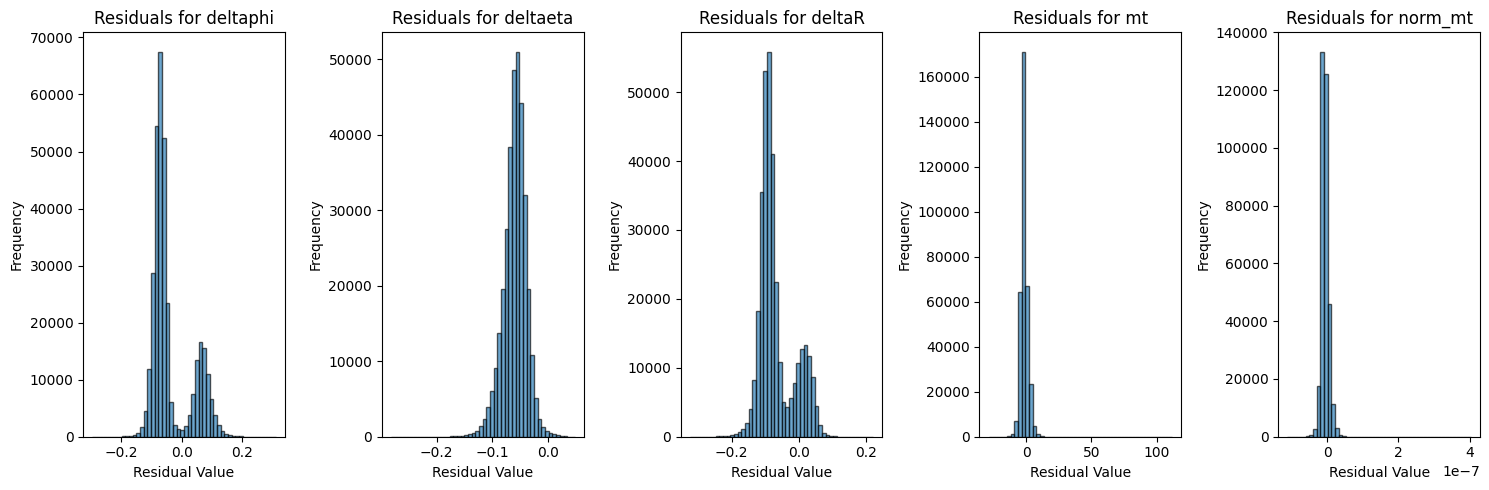

In [17]:
saved_model = KinematicNet()
saved_model.load_state_dict(saved_model_dict)
saved_model.to(device)
saved_model.eval()
# ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12']
out_feats=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt']
num_features = n_l_output.shape[2]
residuals = [[] for _ in range(num_features)]

with torch.no_grad():
    for pair_idx in tqdm(range(len(test_data_list)), desc='Testing', leave=False):
        test_data = test_data_list[pair_idx].to(device)
        test_label = test_labels_list[pair_idx].numpy()  # Convert tensor to numpy
        
        y_pred = saved_model(test_data).cpu().numpy()  # Convert tensor to numpy
        y_pred_inverted = invert_normalize(y_pred, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        test_label_inverted = invert_normalize(test_label, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        
        residuals_pair = y_pred_inverted - test_label_inverted
        
        for i in range(num_features):
            residuals[i].extend(residuals_pair[:, i])

residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays

fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.hist(residuals[i], bins=50, edgecolor='k', alpha=0.65)
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


        



